In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from tabulate import tabulate
from imblearn.over_sampling import SMOTE, RandomOverSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

**Q1**

*Load and explore the training and test dataset, do necessary pre-processing.*

In [2]:
X_train = pd.read_csv('cirrhosis_train.csv')
X_test = pd.read_csv('crrrhosis_test.csv')

*1a: Show both training and test dataset size?*

In [3]:
print('Training dataset size', X_train.shape)
print('Testing dataset size', X_test.shape)

Training dataset size (224, 20)
Testing dataset size (88, 20)


*1b: Based on the training and test data, show the feature types, and indicate which
feature has missing values?*

In [4]:
print('Feature types and missing values in training dataset')
print(X_train.info())

Feature types and missing values in training dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trainID        224 non-null    int64  
 1   N_Days         224 non-null    int64  
 2   Status         224 non-null    object 
 3   Drug           224 non-null    object 
 4   Age            224 non-null    int64  
 5   Sex            224 non-null    object 
 6   Ascites        224 non-null    object 
 7   Hepatomegaly   224 non-null    object 
 8   Spiders        224 non-null    object 
 9   Edema          224 non-null    object 
 10  Bilirubin      224 non-null    float64
 11  Cholesterol    201 non-null    float64
 12  Albumin        224 non-null    float64
 13  Copper         222 non-null    float64
 14  Alk_Phos       224 non-null    float64
 15  SGOT           224 non-null    float64
 16  Tryglicerides  200 non-null    float64
 17  P

In [5]:
missing_value_train_columns = X_train.columns[X_train.isnull().any()].tolist()
print(X_train[missing_value_train_columns].isnull().sum())

Cholesterol      23
Copper            2
Tryglicerides    24
Platelets         3
dtype: int64


In [6]:
print('Feature types and missing values in test dataset')
print(X_test.info())

Feature types and missing values in test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   testID         88 non-null     int64  
 1   N_Days         88 non-null     int64  
 2   Status         0 non-null      float64
 3   Drug           88 non-null     object 
 4   Age            88 non-null     int64  
 5   Sex            88 non-null     object 
 6   Ascites        88 non-null     object 
 7   Hepatomegaly   88 non-null     object 
 8   Spiders        88 non-null     object 
 9   Edema          88 non-null     object 
 10  Bilirubin      88 non-null     float64
 11  Cholesterol    83 non-null     float64
 12  Albumin        88 non-null     float64
 13  Copper         88 non-null     int64  
 14  Alk_Phos       88 non-null     float64
 15  SGOT           88 non-null     float64
 16  Tryglicerides  82 non-null     float64
 17  Platele

In [7]:
missing_value_test_columns = X_test.columns[X_test.isnull().any()].tolist()
print(X_test[missing_value_test_columns].isnull().sum())

Status           88
Cholesterol       5
Tryglicerides     6
Platelets         1
dtype: int64


The values of the “status” column in the test set is leaved with empty to simulate real world predictions.

*1c: Use an appropriate method to deal with the missing values for both the training
and test set?*

Base on the research from BMC Medical Research Methodology team, the most effective imputation results were attained by [KNN](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-024-02173-x)

Therefore we will use KNN to fill na value for this dataset

In [8]:
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

X_train_columns_with_missing = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
X_train[X_train_columns_with_missing] = imputer.fit_transform(X_train[X_train_columns_with_missing])
X_train.isnull().sum().sum()

0

In [9]:
X_test_columns_with_missing = ['Cholesterol', 'Tryglicerides', 'Platelets']
X_test[X_test_columns_with_missing] = imputer.fit_transform(X_test[X_test_columns_with_missing])
X_test.isnull().sum().sum()

88

88 null because the column status is leave for prediction

*1d: Do necessary encoding for the categorical features?*

In [10]:
#checking the categorical feature have binary value or not
cat_columns = X_train.select_dtypes(include=['object']).columns
for col in cat_columns:
    print(col, X_train[col].unique())

Status ['D' 'CL' 'C']
Drug ['Placebo' 'D-penicillamine']
Sex ['M' 'F']
Ascites ['Y' 'N']
Hepatomegaly ['Y' 'N']
Spiders ['N' 'Y']
Edema ['Y' 'S' 'N']


In [11]:
# Define the binary columns
binary_columns = ['Status','Sex','Ascites', 'Hepatomegaly', 'Spiders']
non_binary_columns = ['Drug', 'Edema']

#Label encoding for binary columns
for col in binary_columns:
    if col != 'Status':
        X_train[col] = LabelEncoder().fit_transform(X_train[col])
        X_test[col] = LabelEncoder().fit_transform(X_test[col])
    if col == 'Status':
        status_mapping = {'D': 0, 'C': 1, 'CL': 2}
        X_train['Status'] = X_train['Status'].map(status_mapping)

# Get dummies for non-binary columns in X_train
dummies_train = pd.get_dummies(X_train[non_binary_columns]).astype('int')
X_train = pd.concat([X_train.drop(non_binary_columns, axis=1), dummies_train], axis=1)
# Get dummies for non-binary columns in X_test
dummies_test = pd.get_dummies(X_test[non_binary_columns]).astype('int')
X_test = pd.concat([X_test.drop(non_binary_columns, axis=1), dummies_test], axis=1)


*1e: Show the label distribution based on the training data, is it a balanced training set?*

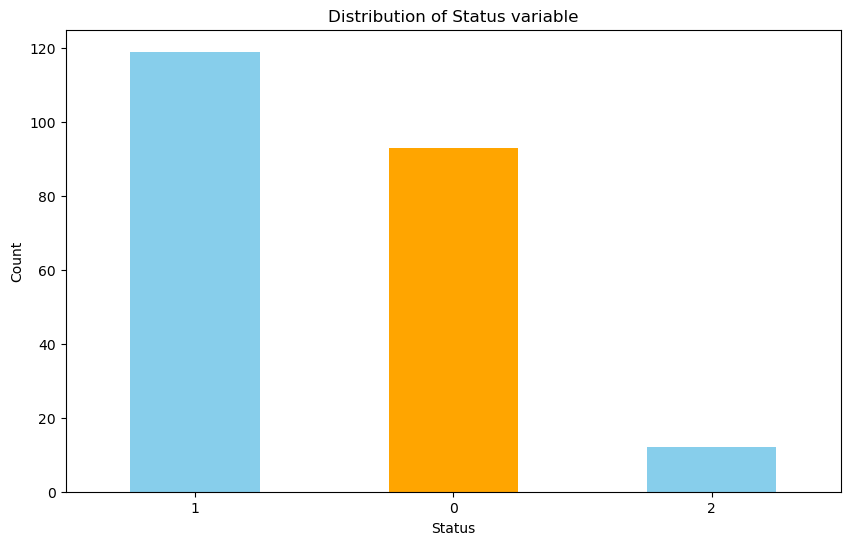

In [12]:
plt.figure(figsize=(10, 6))
X_train['Status'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Status variable')
plt.xticks(rotation=0)
plt.show()

The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)

The distribution of label is an imbalance data set, we see C (1) > D (0) > CL (2). The differece between CL and the others 2 is highly significant, it take approximately 10% of the label distribution, the rest is shared with C and D which is not so much difference.

**Q2**

*Create three supervised machine learning (ML) models for predicting “Status”.*

Predicting the survival state of patients with liver cirrhosis, where the states include "0 = D (death)", "1 = C (censored)", and "2 = CL (censored due to liver transplantation)", is a classification problem. 

In this scenario, we are classifying each patient into one of multiple distinct categories based on their survival status. Each category (death, censored, censored due to liver transplantation) is a separate class, making this a multi-class classification problem.

To solve this classification problem, I'll build 3 different models: Neural Network, Random Forest, SVM.

In [13]:
#Splitting the data into features and target
X_train_features = X_train.drop('Status', axis=1)
y_train = X_train['Status']

In [14]:
#Resampling using RandomOverSampler
res = RandomOverSampler(random_state=42)
X_res, y_res = res.fit_resample(X_train_features, y_train)

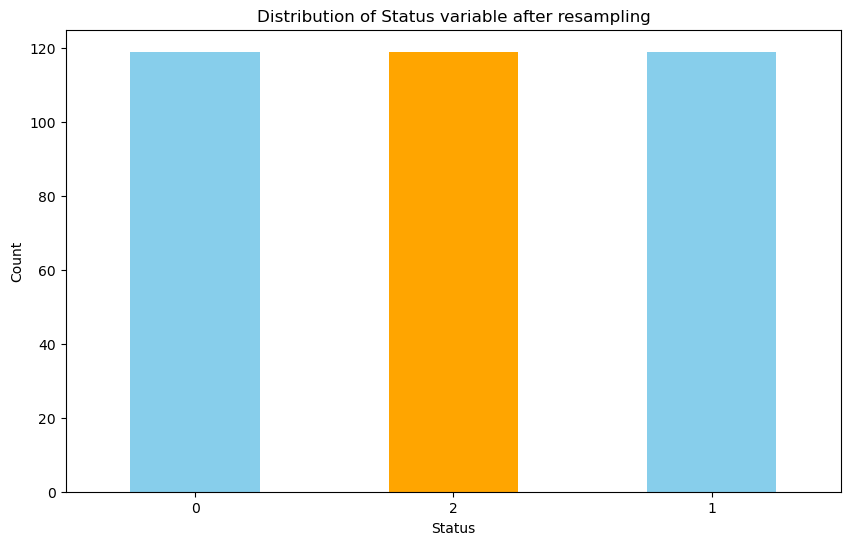

In [15]:
#Check the imbalance in the target variable
plt.figure(figsize=(10, 6))
y_res.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Status variable after resampling')
plt.xticks(rotation=0)
plt.show()

In [16]:
#Cross-validation to split the dataset into training and validation sets
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, val_index in kf.split(X_res):
    X_train_fold, X_val_fold = X_res.iloc[train_index], X_res.iloc[val_index]
    y_train_fold, y_val_fold = y_res.iloc[train_index], y_res.iloc[val_index]
#Sandardization of data
X_train_fold = StandardScaler().fit_transform(X_train_fold)
X_val_fold = StandardScaler().fit_transform(X_val_fold)

In [17]:
y_train_fold.value_counts()

Status
1    99
0    96
2    91
Name: count, dtype: int64

In [18]:
y_val_fold.value_counts()

Status
2    28
0    23
1    20
Name: count, dtype: int64

Build Neural Network model

In [19]:
nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(15,), learning_rate='constant',tol=0.01 , random_state=1)
nn.fit(X_train_fold, y_train_fold)
y_pred_nn = nn.predict(X_val_fold)


Build Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_fold, y_train_fold)
y_pred_rf = rf.predict(X_val_fold)

Build RBF SVM (since the data is non-linear)

In [21]:
svm_clf = svm.SVC(kernel='rbf', C=1, gamma='auto')
svm_clf.fit(X_train_fold, y_train_fold)
y_pred_svm = svm_clf.predict(X_val_fold)

Evaluation using Classification report, but we want a focus on Precision and Recall metrics because the target class is imbalance

In [22]:
eval_nn = classification_report(y_val_fold, y_pred_nn)
eval_rf = classification_report(y_val_fold, y_pred_rf)
eval_svm = classification_report(y_val_fold, y_pred_svm)

print(tabulate([['Neural Network', eval_nn], ['Random Forest', eval_rf], ['SVM', eval_svm]], headers=['Model', 'Evaluation'], tablefmt='orgtbl'))

| Model          | Evaluation                                            |
|----------------+-------------------------------------------------------|
| Neural Network | precision    recall  f1-score   support               |
|                |                                                       |
|                |            0       0.84      0.70      0.76        23 |
|                |            1       0.49      0.85      0.62        20 |
|                |            2       0.76      0.46      0.58        28 |
|                |                                                       |
|                |     accuracy                           0.65        71 |
|                |    macro avg       0.70      0.67      0.65        71 |
|                | weighted avg       0.71      0.65      0.65        71 |
| Random Forest  | precision    recall  f1-score   support               |
|                |                                                       |
|                |       

**SVM** shows the best overall performance, managing to effectively balance both precision and recall across all classes, making it the best model among the three for this dataset.

**Random Forest** shows competency, especially in handling class 2 with perfect recall, but struggles with precision for this class.

**Neural Network** require further tuning as it shows the least consistent performance across the classes, particularly struggling with class 1 and 2.

**Detect overfitting and underfitting**

while SVM performs best overall, even its recall and F1-scores for class 1 are zero, suggesting potential overfitting to the majority classes or underfitting to class 1. 

To detect overfitting and underfitting, i plot learning curve on the training data and the evaluation data.

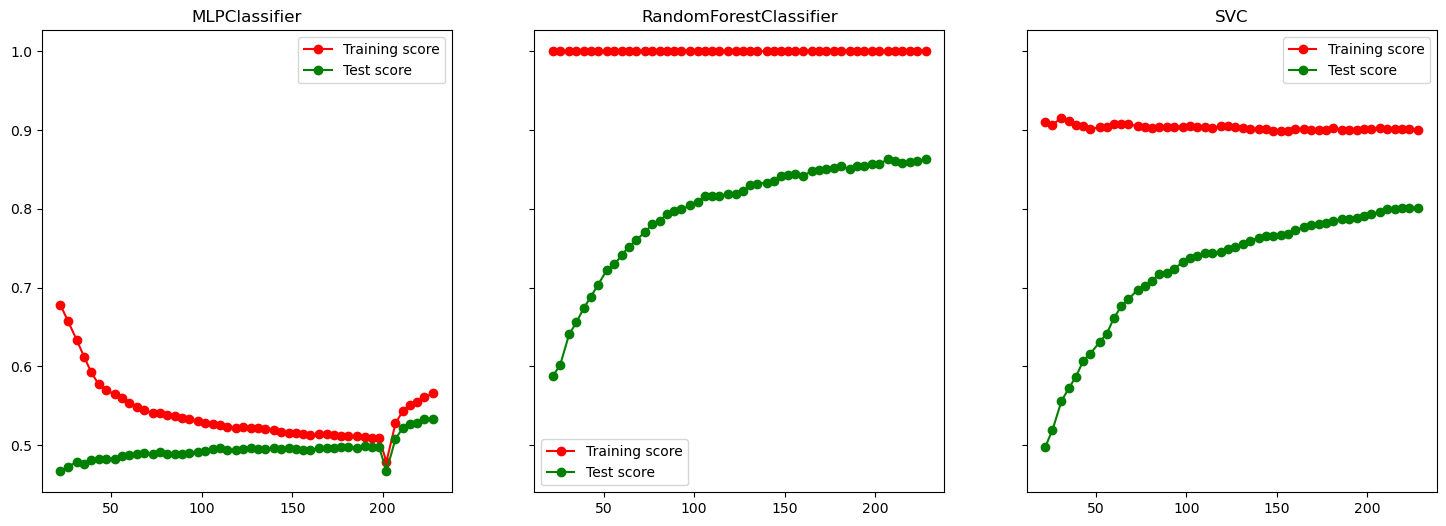

In [23]:
#Learning curve
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

common_params = {
    'X': X_train_fold,
    'y': y_train_fold,
    'train_sizes': np.linspace(0.1, 1.0, 50),
    'cv': ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
    'scoring': 'accuracy', 
    'n_jobs': -1,
    }

for i, model in enumerate([nn, rf, svm_clf]):
    train_sizes, train_scores, test_scores = learning_curve(model, **common_params)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    ax[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
    ax[i].set_title(model.__class__.__name__)
    ax[i].legend(loc="best")
plt.show()

**MLPClassifier**: Might benefit from a more complex model structure or different regularization techniques to help it capture more complexity in the data without losing the ability to generalize. Adjusting parameters like learning rate, adding layers, or changing activation functions could be explored.

**RandomForestClassifier and SVC**: Both models exhibit a good fit since the test score gradually aproach the high accuracy score. However it will also be a sign of overfit, we should:

- Implementing cross-validation to better gauge generalization across different subsets of data.

- Introducing regularization techniques or pruning methods in the case of RandomForest.

- For SVC, exploring parameter adjustments such as the penalty parameter C or trying a different kernel might help.

Reducing model complexity by lowering the number of estimators in RandomForest or simplifying the decision boundaries in SVC could also be beneficial.

**Hyperparameter tuning**

In [35]:
# Define the models and their respective parameter grids
models_params = [
    (nn, {'hidden_layer_sizes': [(10,), (15,), (20,)], 'alpha': [1e-5, 1e-4, 1e-2], 'learning_rate': ['constant', 'adaptive','invscaling'], 'solver': ['adam', 'sgd', 'lbfgs']}),
    (rf, {'n_estimators': [5, 10, 20 ,50, 100, 150, 200, 250, 300], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20, 25, 30, 50, 100, 200], 'max_features': ['sqrt', 'log2', None, 0.5, 0.75, 1, 2, 3, 4, 5]}),
    (svm_clf, {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'probability': [True, False]})
]

# Initialize the F1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform grid search for each model
for model, param_grid in models_params:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer, n_jobs=4)
    grid_search.fit(X_train_fold, y_train_fold)
    print('Model:', model.__class__.__name__)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Best F1 score:', grid_search.best_score_)
    print('Best model:', grid_search.best_estimator_)
    print('\n')

Model: MLPClassifier
Best hyperparameters: {'alpha': 0.01, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best F1 score: 0.7863792107319736
Best model: MLPClassifier(alpha=0.01, hidden_layer_sizes=(20,), random_state=1,
              solver='lbfgs', tol=0.01)


Model: RandomForestClassifier
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'n_estimators': 150}
Best F1 score: 0.8875518912995455
Best model: RandomForestClassifier(criterion='entropy', max_depth=10, max_features=1,
                       n_estimators=150, random_state=0)


Model: SVC
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Best F1 score: 0.8053263128563867
Best model: SVC(C=1, probability=True)




**Handle imbalanced label dataset by Voting essembler**


**Re-build model**

In [36]:
#Neuro Network
nn_best = MLPClassifier(alpha=0.01, hidden_layer_sizes=(20,), learning_rate='constant', solver='lbfgs', random_state=1)

#Random Forest
rf_best = RandomForestClassifier(criterion='entropy',max_depth=10, n_estimators=150, max_features=1,random_state=0)

#SVM
svm_clf_best = svm.SVC(C=1, gamma='scale', kernel='rbf', probability=True)


In [37]:
#Voting Essamble
eclf = VotingClassifier(estimators=[('nn', nn_best), ('rf', rf_best), ('svm', svm_clf_best)], voting='hard')
eclf.fit(X_train_fold, y_train_fold)
y_pred_eclf = eclf.predict(X_val_fold)

#evaluation of ensemble model
eval_eclf = classification_report(y_val_fold, y_pred_eclf)
print('Ensemble Model Evaluation')
print(eval_eclf)

Ensemble Model Evaluation
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.84      0.80      0.82        20
           2       1.00      1.00      1.00        28

    accuracy                           0.90        71
   macro avg       0.89      0.89      0.89        71
weighted avg       0.90      0.90      0.90        71



/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

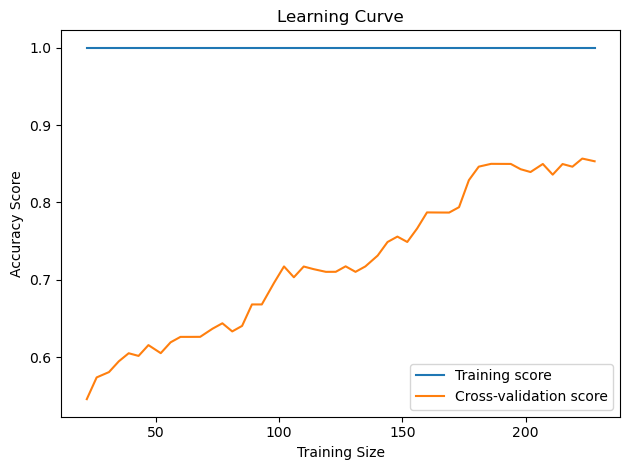

In [38]:
common_params_eclf = {
    'X': X_train_fold,
    'y': y_train_fold,
    'train_sizes': np.linspace(0.1, 1.0, 50),
    'cv': 5,
    'scoring': 'accuracy', 
    'n_jobs': -1,
    }

train_sizes_eclf, train_scores_eclf, test_scores_eclf = learning_curve(eclf, **common_params_eclf)
train_mean_eclf = np.mean(train_scores_eclf, axis=1)
test_mean_eclf = np.mean(test_scores_eclf, axis=1)

# Plot the learning curve
plt.plot(train_sizes_eclf, train_mean_eclf, label='Training score')
plt.plot(train_sizes_eclf, test_mean_eclf, label='Cross-validation score')

# Create plot
plt.title('Learning Curve')
plt.xlabel('Training Size'), plt.ylabel('Accuracy Score'), plt.legend(loc='best') 
plt.tight_layout()
plt.show()

The model now in the best fit, after tuning hyperparemeter, resampling and voting essembler

**Q3**

Use the best model that you get from question 2, do prediction on the pre-processed test set.

In [39]:
# #Sandardization of data
X_train_scale = StandardScaler().fit_transform(X_train_features)
X_test_scale = StandardScaler().fit_transform(X_test.drop(['Status'], axis=1))

#Fit the model
eclf.fit(X_train_scale, y_train)
y_pred = eclf.predict(X_test_scale)

#inverse_transform the label encoding
inverse_status_mapping = {0: 'D', 1: 'C', 2: 'CL'}
y_pred = pd.DataFrame(y_pred, columns=['Status'], index=X_test['testID'])
y_pred['Status'] = y_pred['Status'].map(inverse_status_mapping)
y_pred.to_csv('cirrhosis_predictions.csv', index=True)


In [40]:
y_train.value_counts()

Status
1    119
0     93
2     12
Name: count, dtype: int64

In [41]:
y_pred.value_counts()

Status
C         54
D         34
Name: count, dtype: int64

**Q4**

Analyse the importance of the features for predicting “Status” using two different approaches. Give statistical reasons of your findings.

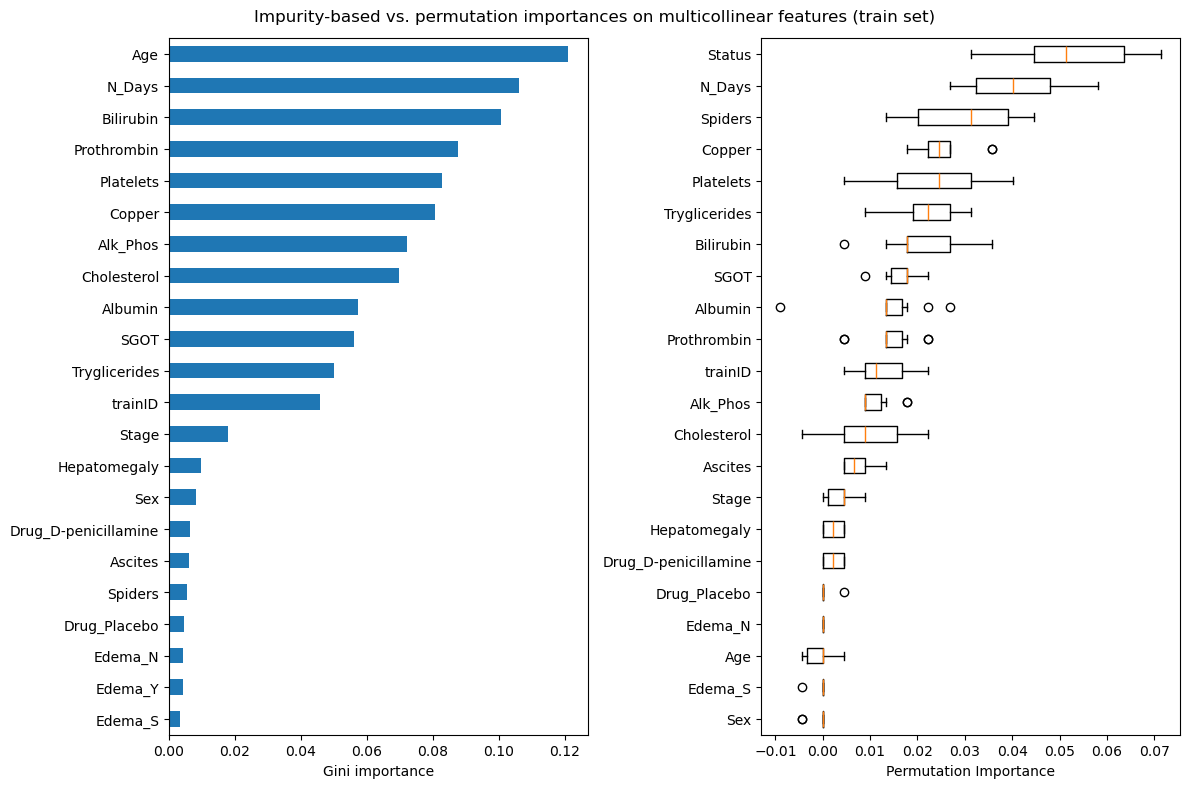

In [31]:
# Get feature importances from random forest
rf_importances = pd.Series(rf.feature_importances_, index=X_train_features.columns)

# Sort the importances
tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

# Plot Gini importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
rf_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")

# Calculate and plot permutation importances
result = permutation_importance(rf, X_train_scale, y_train, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax2.set_xlabel("Permutation Importance")

# Set title and layout
fig.suptitle("Impurity-based vs. permutation importances on multicollinear features (train set)")
fig.tight_layout()

Consistency Between Measures: When both types of importance agree on a feature's significance (N_Days), it has real impact on the model.

Differences Between Measures: Permutation importance can sometimes provide a more reliable measure as it directly measures performance degradation and is not biased by the intrinsic data structure as impurity-based importance might be.

Features with Low Importance:Features like Edema_S, Drug_Placebo, Spiders, and others at the bottom of the impurity-based importance might be caused by the result of dummy encoder from categorical variables.

Normally, even features showing low importance in both measures should be carefully evaluated before removal, however it should also considering potential impacts in specific contexts or in combination with other features.

**Feature selection**

In [34]:
#Select top 10 importances
top10 = rf_importances.sort_values(ascending=False).head(11).drop('N_Days')

#Retrain models
X_train_features_top10 = X_train_features[top10.index]
X_train_scale_top10 = StandardScaler().fit_transform(X_train_features_top10)
X_test_scale_top10 = StandardScaler().fit_transform(X_test[top10.index])

rf.fit(X_train_scale_top10, y_train)
y_pred_top10 = eclf.predict(X_test_scale)

y_pred_top10 = pd.DataFrame(y_pred_top10, columns=['Status'], index=X_test['testID'])
y_pred_top10['Status'] = y_pred_top10['Status'].map(inverse_status_mapping)
y_pred_top10.to_csv('cirrhosis_predictions_top10.csv', index=True)
